# Image Downsampling and Gridpoint/Trajectory Notebook

- This notebook provides the high level overview for downsampling the image via the use of grid points and subsequently calculating motion trajetcories that encode the global motion of a video

In [1]:
import sys
sys.path.insert(0, '/Users/jaredperez/Documents/computer_vision/')
import matplotlib.pyplot as plt
from farkenbach_utils import Utils
f_utils = Utils()
from model_utils import *
import torch
from CNN import miniNet, Inference
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import median_filter

### Downlod frames and calculate optical flows

In [2]:
con_path='/Users/jaredperez/Documents/computer_vision/exercises/curls/curls_frames/Screen Recording 2023-07-07 at 8.40.54 AM_30fps.mov/concentric'
ecc_path = '/Users/jaredperez/Documents/computer_vision/exercises/curls/curls_frames/Screen Recording 2023-07-07 at 8.40.54 AM_30fps.mov/eccentric'


con_flow, con_path, con_reps = f_utils.farkenbach_video_processing(con_path, 328, 256)

ecc_flow, ecc_path, ecc_reps = f_utils.farkenbach_video_processing(ecc_path, 328, 256)

con_flow = np.stack(con_flow)
ecc_flow = np.stack(ecc_flow)

print(con_flow.shape)
print(ecc_flow.shape)

#Check to make sure flows came out different after weird problem previously
print(np.unique(con_flow[1]==con_flow[0]))

(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 328, 3)
(256, 

### Apply the grid points function

In [3]:
def devlop_grid_points(flow_batch, grid_size=8, max_length=15, drift_threshold=10):
    #Takes in inputs that have been reshaped by 
    W, H = flow_batch.shape[2], flow_batch.shape[1]
    start_points = np.mgrid[grid_size//2:H:grid_size, grid_size//2:W:grid_size].transpose(1,2,0)
    start_points = np.minimum(start_points, np.array([H-1, W-1]))

    trajectories = []
    trajectory_lengths = np.zeros_like(start_points[..., 0])
    trajectory_starts = np.copy(start_points)

    # Iterate over frames in batch
    for i in range(flow_batch.shape[0]):
        # Update points
        points = start_points + flow_batch[i, start_points[:, :, 0].astype(int), start_points[:, :, 1].astype(int)]

        # Check for trajectories that have reached their maximum length
        max_length_mask = trajectory_lengths >= max_length
        points[max_length_mask] = trajectory_starts[max_length_mask]
        trajectory_lengths[max_length_mask] = 0

        # Check for trajectories that have drifted too far
        drift_mask = np.linalg.norm(points - trajectory_starts, axis=-1) > drift_threshold
        points[drift_mask] = trajectory_starts[drift_mask]
        trajectory_lengths[drift_mask] = 0

        # Store the updated points
        trajectories.append(points)

        # Increment the lengths of the trajectories
        trajectory_lengths += 1

    return trajectories


In [4]:
con_grid = devlop_grid_points(con_flow)
ecc_grid = devlop_grid_points(ecc_flow)


con_grid=np.stack(con_grid)
ecc_grid=np.stack(ecc_grid)
ecc_grid.shape

(124, 32, 41, 2)

- Grid is in shape (frames, y_location, x_location, (x_pixel_location, y_pixel_location))

### Visualize Grid

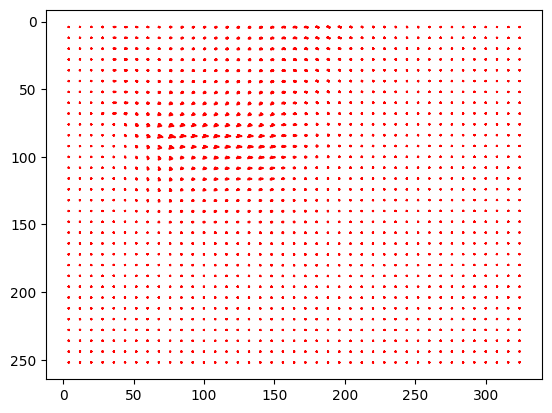

In [10]:
num=12

grid = ecc_grid
path = ecc_path

image = cv2.imread(path[num])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (328,256))

# Create a new figure and axis
fig, ax = plt.subplots()

# ax.imshow(image)

# Get the number of grid points in the x and y directions
grid_y, grid_x = grid.shape[1:3]

# Plot the trajectories
for i in range(grid_y):
    for j in range(grid_x):
        # Get the x and y coordinates of the points in the trajectory
        x_coords = grid[:num, i, j, 1] 
        y_coords = grid[:num, i, j, 0]

        # Plot the trajectory
        ax.plot(x_coords, y_coords, color='r')

plt.ylim(plt.ylim()[::-1]) #Inverts y axis to match image, not needed when image is included

# Show the plot
plt.show()


### Visualize motion of grid points along pixels

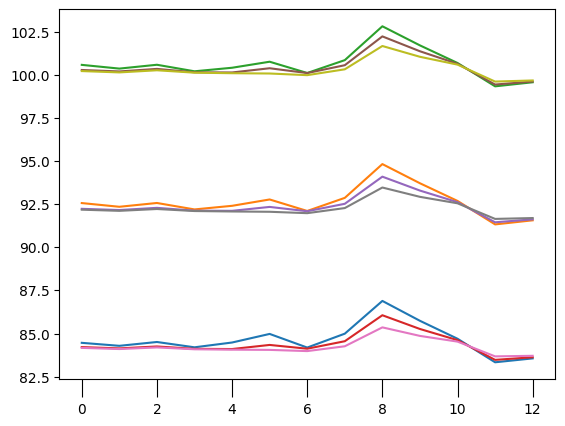

In [11]:
### Plot multiple grid points


frames = 13 #How many frames to go to, first rep for this example goes to about 13
points = 3     #How many grid points to plot
start=10       
end=13          #(sart, end) == (y,x) grid point to plot
grid = ecc_grid
direction = 1 #1 for y/0 for x

fig, ax = plt.subplots()

for i in range(start, end):
    for j in range(start, end):
        y_coords = grid[:frames, i, j, direction]

        x_coords = np.arange(len(y_coords))

        ax.plot(x_coords, y_coords, label = f'Grid point ({i}, {j})')


# ax.legend()
plt.tick_params('x', length =frames)
plt.show()

### Develop the motion trajectories from the grid points (displacement vectors encoding the motion of each grid point across frames)

In [12]:
def process_trajectory_vectors(trajectories):
    displacements = np.diff(trajectories, axis=0)

    # Compute the magnitudes of the displacement vectors
    magnitudes = np.linalg.norm(displacements, axis=-1)

    # Create empty array to store the normalized vectors and filtered vectors
    filtered_vectors = np.full_like(trajectories, None)
    filtered_vectors = np.delete(filtered_vectors, 0, axis=0)

    # Iterate over all grid points
    for i in range(displacements.shape[1]):
        for j in range(displacements.shape[2]):
            # Normalize the magnitudes
            sum_of_magnitudes = np.sum(magnitudes[:, i, j])
            if sum_of_magnitudes == 0:  # Avoid division by zero
                sum_of_magnitudes = 1
            norm_vector = displacements[:, i, j] / sum_of_magnitudes

            # Prune static and erratic trajectories
            if np.any(np.abs(norm_vector) <= 0.7):
                filtered_vectors[:, i, j] = norm_vector

    return filtered_vectors*10

In [15]:
con_vectors = process_trajectory_vectors(con_grid)
ecc_vectors = process_trajectory_vectors(ecc_grid)

con_first_rep = con_vectors[:12]
ecc_first_rep = ecc_vectors[:13]

### Plot the trajetcories for each grid point

- quiver plot showing motion with arrows

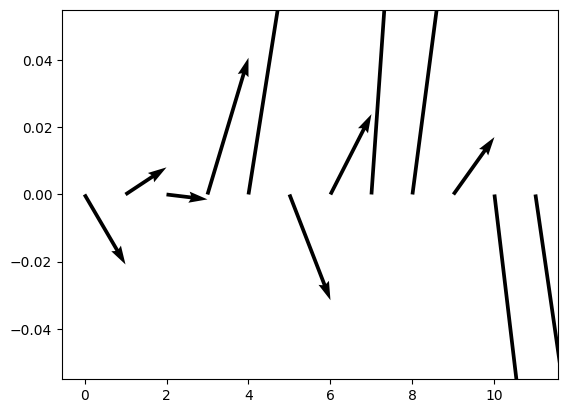

In [16]:
# x-values (frame numbers)
x_values = np.arange(ecc_first_rep.shape[0])

# y-values (displacements)
y_values = np.cumsum(ecc_first_rep[:,9, 12, 1])

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the vectors
ax.quiver(x_values[:-1], np.zeros_like(x_values[:-1]), np.ones_like(x_values[:-1]), y_values[:-1], angles='xy', scale_units='xy', scale=1)

# Show the plot
plt.show()


- Length of arrow in horizontal and vertical direction indicates relative motion of this grid point across the 13 frames

### Normal line graph showing magnitude of motion in both X and Y direction

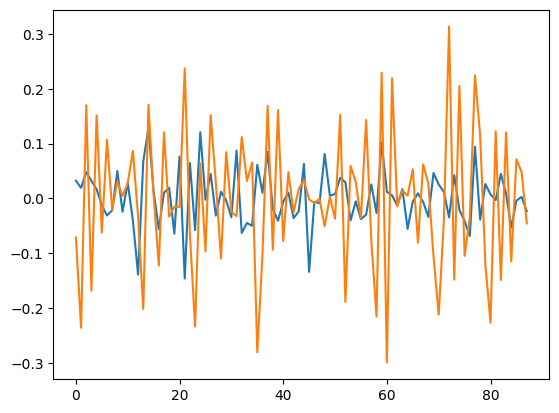

In [26]:
fig, ax = plt.subplots()

plt.plot(con_vectors[:,9, 12, :])

plt.show()


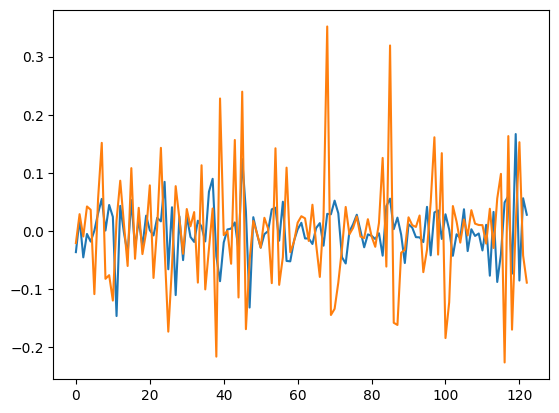

In [28]:
plt.plot(ecc_vectors[:,9, 12, :])
plt.show()

- Across both graphs we can see a nice periodicty to both the upwards and downwards motions and we see greater motion in the Y direction for b oth upwards and downawards motions which corresponds with the true motion